In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import re
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import numpy as np

In [3]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [4]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

In [5]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA50,X14_ CA59,Y
0,-1.520449,-1.428585,1.530877,-1.162058,-0.836349,-0.535183,-1.042610,-2.433676,-0.612921,-0.707368,0.0,0.0,1.0,0.0,0.0,0.0,Mercedes
1,0.019717,-0.578489,1.649464,-0.522458,-0.204228,-0.694313,1.210780,-1.719345,-2.155114,-0.453929,0.0,1.0,0.0,0.0,0.0,0.0,BMW
2,-1.149807,0.019739,0.226418,-0.658669,-0.263490,-0.870256,1.034734,0.185537,-0.753121,-0.819252,0.0,0.0,1.0,0.0,0.0,0.0,Honda
3,-1.708274,-0.415010,1.530877,-0.984392,-0.540042,-1.025183,1.316407,-1.147880,-1.944815,-0.890957,0.0,0.0,1.0,0.0,0.0,0.0,Honda
4,-1.034608,-0.534895,1.175115,0.667908,1.711888,-0.910489,1.210780,-1.100258,-1.734516,-0.234488,0.0,0.0,1.0,1.0,0.0,0.0,Mercedes


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,6714,object,6
X1,X1,6714,float64,1393
X2,X2,6714,float64,2763
X3,X3,6714,float64,48
X4,X4,6714,float64,657
X5,X5,6714,float64,306
X6,X6,6714,float64,3077
X7,X7,6714,float64,167
X8,X8,6714,float64,131
X9,X9,6714,float64,243


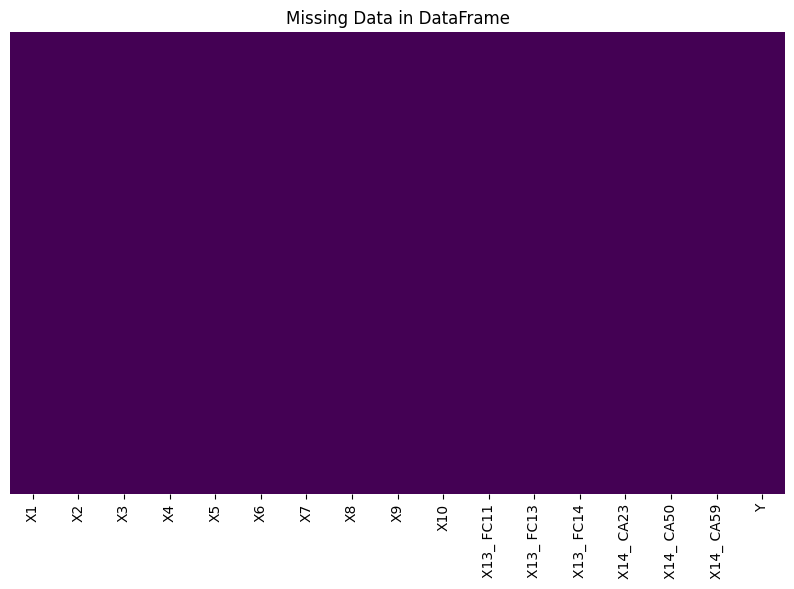

In [6]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [7]:
X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = pd.get_dummies(train_data['Y'], dtype='float32').to_numpy()

X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = pd.get_dummies(val_data['Y'], dtype='float32').to_numpy()

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = pd.get_dummies(test_data['Y'], dtype='float32').to_numpy()


In [8]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [9]:
classes = train_data["Y"].unique()
num_classes = y_train.shape[1]
input_features = X_train.shape[1]
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {num_classes}")
print(f"Number of features: {input_features}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}" )

print(categorical_cols)

The classes is: ['Mercedes' 'BMW' 'Honda' 'Toyota' 'GMC' 'Ford']
Number of classes: 6
Number of features: 16
X_train shape: (6714, 16), y_train shape: (6714, 6)
Index(['Y'], dtype='object')


# Building Model

In [10]:
# define the CNN model using Sequential method
from keras import Input, Model
from keras.layers import Dense
from keras.metrics import Precision, F1Score



def build_model(input_features, num_classes):
    # Create model
    input_data = Input(shape=(input_features,))
    x = Dense(64, activation='relu')(input_data)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_data, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(average="weighted")])

    return model



model = build_model(input_features, num_classes)

# Model summary
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 6)                 102       
                                                                 
Total params: 14166 (55.34 KB)
Trainable params: 14166 (55.

In [11]:
class PrintMetricsEveryNEpochs(Callback):
    def __init__(self, n_epochs=5):
        self.n_epochs = n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n_epochs == 0:
            print(f"Epoch {epoch + 1}:")
            for metric, value in logs.items():
                print(f"{metric}: {value:.2f}")

            print()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=True,
    mode='min',
    restore_best_weights=True
)


# Create an instance of the custom callback
print_metrics = PrintMetricsEveryNEpochs(n_epochs=5)

# Include this callback in your model.fit call along with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=False,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, print_metrics]  # Add the custom callback
)



Epoch 5:
loss: 0.23
f1_score: 0.91
val_loss: 0.32
val_f1_score: 0.87

Epoch 10:
loss: 0.18
f1_score: 0.93
val_loss: 0.30
val_f1_score: 0.88

Epoch 15:
loss: 0.15
f1_score: 0.94
val_loss: 0.30
val_f1_score: 0.88

Epoch 20:
loss: 0.13
f1_score: 0.95
val_loss: 0.32
val_f1_score: 0.89

Epoch 25:
loss: 0.12
f1_score: 0.95
val_loss: 0.30
val_f1_score: 0.89

Epoch 30:
loss: 0.10
f1_score: 0.97
val_loss: 0.31
val_f1_score: 0.90

Epoch 35:
loss: 0.08
f1_score: 0.97
val_loss: 0.27
val_f1_score: 0.91

Epoch 40:
loss: 0.08
f1_score: 0.97
val_loss: 0.26
val_f1_score: 0.91

Epoch 45:
loss: 0.07
f1_score: 0.98
val_loss: 0.30
val_f1_score: 0.91

Epoch 50:
loss: 0.06
f1_score: 0.98
val_loss: 0.33
val_f1_score: 0.90

Epoch 55:
loss: 0.06
f1_score: 0.98
val_loss: 0.31
val_f1_score: 0.91

Epoch 60:
loss: 0.05
f1_score: 0.98
val_loss: 0.27
val_f1_score: 0.92

Epoch 65:
loss: 0.04
f1_score: 0.98
val_loss: 0.27
val_f1_score: 0.93

Epoch 70:
loss: 0.04
f1_score: 0.99
val_loss: 0.28
val_f1_score: 0.93

Restor

In [12]:
# Final evaluation of the model
loss, acc = model.evaluate(X_test, y_test)
print("Test F1 Score: %.2f%%" % (acc*100))

29/29 [==============================] - 0s 893us/step - loss: 0.3533 - f1_score: 0.9270
Test F1 Score: 92.70%


In [13]:


# Get predictions for the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print(report)


29/29 [==============================] - 0s 679us/step
              precision    recall  f1-score   support

    Mercedes       0.92      0.96      0.94       221
         BMW       0.70      0.74      0.72        19
       Honda       0.93      0.93      0.93        46
      Toyota       0.91      0.91      0.91       211
         GMC       0.95      0.94      0.95       246
        Ford       0.94      0.90      0.92       174

    accuracy                           0.93       917
   macro avg       0.89      0.90      0.90       917
weighted avg       0.93      0.93      0.93       917



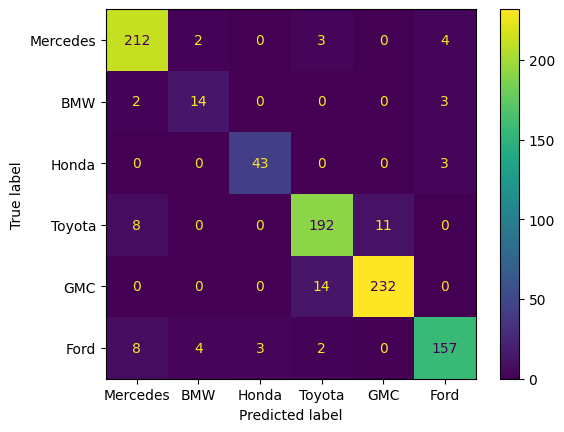

In [14]:
confusion_matrix = confusion_matrix(y_true_classes, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)

cm_display.plot()
plt.show()